In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# cwd
print(f'Current working directory: {os.getcwd()}')
# change directory
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

/var/folders/83/j83q5_mj11956_7k9tnld0ym0000gn/T/ipykernel_49320/3914640498.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Current working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling/notebooks
New working directory: /Users/gbemidebe/Documents/GitHub/CDImodeling


In [2]:
from cdi.plotters import Plotters

plotter = Plotters()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


SA --> surface area 
DG --> defect ratio
%N --> percent nitrogen
%O --> percent oxygen
%S --> percent sulphur
CD --> current density
CONC --> concentration of electrolyte
CAP --> specific capacitance

In [3]:
import pandas as pd

desired_columns = ['VW', 'FR', 'CNaCl', 'SSA', 'PV', 'Psave', 'PVmicro', 'ID/IG', 'N', 'O', 'EC']

data = pd.read_excel('data/not_time_series/cdi_data.xlsx', sheet_name='data_cleaned')
data = data[desired_columns]
print(data.shape)
data.head()

(583, 11)


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
0,1.2,9.0,390.0,651.0,0.50,3.07,0.18,NaN,NaN,NaN,6.40
1,1.2,9.0,390.0,512.0,0.29,2.27,0.23,NaN,NaN,NaN,4.60
2,1.0,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,10.00
3,0.6,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,5.63
4,0.8,25.0,292.0,1877.0,2.40,5.11,0.30,0.92,4.6,NaN,8.20


In [4]:
for col in data.columns:
    print(f'% of missing values in {col}: {data[col].isna().sum()/len(data)*100:.2f}%')

% of missing values in VW: 0.00%
% of missing values in FR: 1.37%
% of missing values in CNaCl: 0.00%
% of missing values in SSA: 0.00%
% of missing values in PV: 1.72%
% of missing values in Psave: 0.34%
% of missing values in PVmicro: 54.89%
% of missing values in ID/IG: 31.22%
% of missing values in N: 26.93%
% of missing values in O: 29.50%
% of missing values in EC: 0.00%


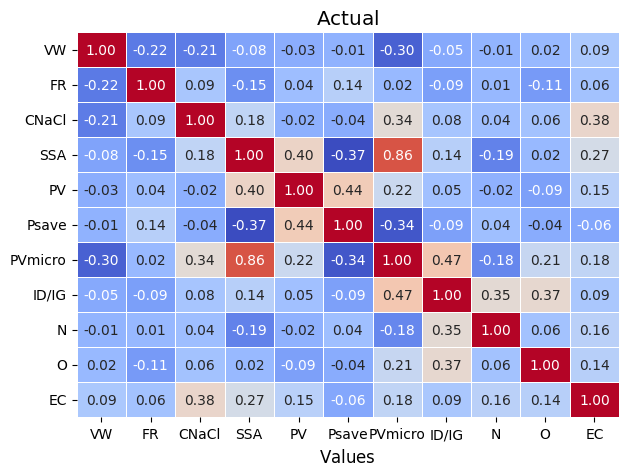

In [5]:
plotter.plot_heat_map(data=data, label = r'$ \rm Actual$', property = 'original',
                    fig_size = (7, 5), save_fig = False)

In [6]:
# drop missing values
clean_data = data.dropna()
print(clean_data.shape)
clean_data.head()

(105, 11)


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
20,1.0,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,13.30
21,1.1,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,5.30
22,1.2,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,3.10
183,2.0,10.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,7.25
184,2.0,15.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,6.55


## Imputation

In [7]:
import pandas as pd
import numpy as np
from loguru import logger
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

from cdi.dataPreprocessing import Imputation

In [8]:
# create artificial missing values
def introduce_missing_values(dataframe, missing_fraction):
    mask = np.random.rand(*dataframe.shape) < missing_fraction
    dataframe[mask] = np.nan
    return dataframe

# Function to introduce artificial missing values in specific columns
def introduce_missing_values_in_columns(dataframe, columns, missing_fraction):
    for col in columns:
        mask = np.random.rand(dataframe[col].shape[0]) < missing_fraction
        dataframe.loc[mask, col] = np.nan
    return dataframe

In [9]:
import random
# set random state to reproduce the same results
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

In [10]:
idx = 'EC' 

### Case 1: 20%

In [11]:
missing_fraction = 0.2
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
20,1.0,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,13.30
21,1.1,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,5.30
22,1.2,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,NaN
183,2.0,10.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,7.25
184,2.0,15.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,NaN


In [12]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in VW: 0.00%
% of missing values in FR: 0.00%
% of missing values in CNaCl: 0.00%
% of missing values in SSA: 0.00%
% of missing values in PV: 0.00%
% of missing values in Psave: 0.00%
% of missing values in PVmicro: 0.00%
% of missing values in ID/IG: 0.00%
% of missing values in N: 0.00%
% of missing values in O: 0.00%
% of missing values in EC: 23.81%


#### KNN

In [13]:
# fill data
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:20.991 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O     EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  13.30
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20    NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   7.25
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99    NaN
2024-02-15 12:40:20.994 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 12:40:20.995 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:20.996 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:20.997 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:20.997 | WARNING  | cdi.d

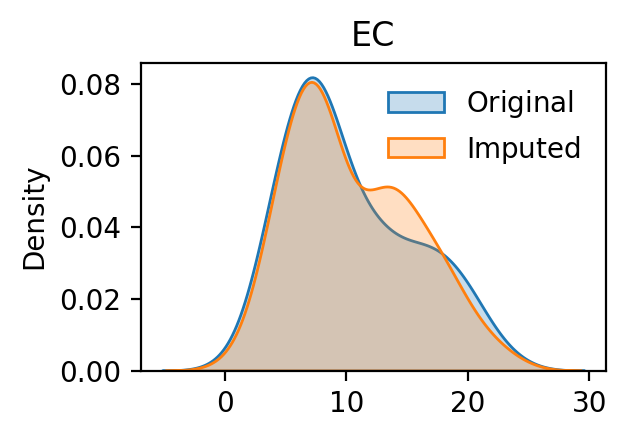

In [14]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

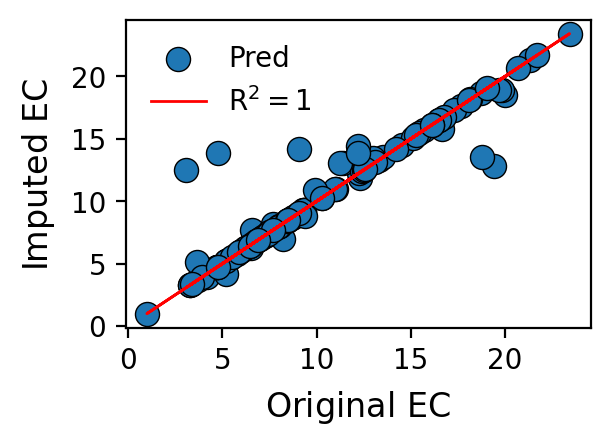

In [15]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [16]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 1.68
MAE: 0.53
R2: 0.90


#### Extra Tree Regressor

In [17]:
# fill data

method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=200)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:21.500 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O     EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  13.30
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20    NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   7.25
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99    NaN
2024-02-15 12:40:21.501 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 12:40:21.502 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:21.503 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:21.503 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:21.504 | 

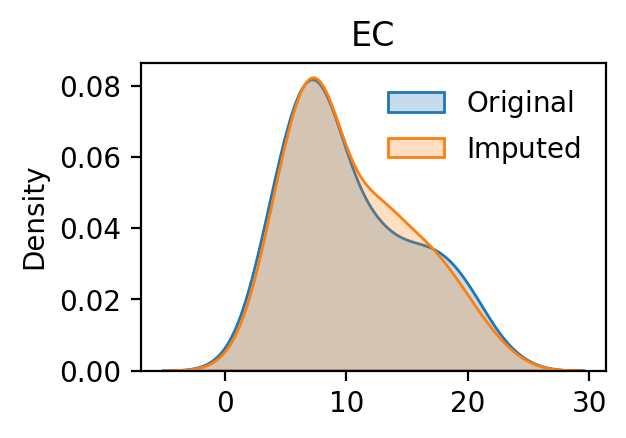

In [18]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

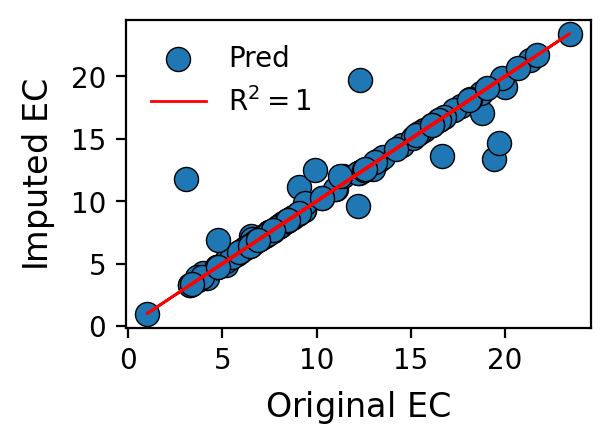

In [19]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [20]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 1.48
MAE: 0.45
R2: 0.92


### Case 2: 50%

In [21]:
missing_fraction = 0.5
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
20,1.0,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,13.30
21,1.1,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,5.30
22,1.2,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,NaN
183,2.0,10.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,NaN
184,2.0,15.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,6.55


In [22]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in VW: 0.00%
% of missing values in FR: 0.00%
% of missing values in CNaCl: 0.00%
% of missing values in SSA: 0.00%
% of missing values in PV: 0.00%
% of missing values in Psave: 0.00%
% of missing values in PVmicro: 0.00%
% of missing values in ID/IG: 0.00%
% of missing values in N: 0.00%
% of missing values in O: 0.00%
% of missing values in EC: 51.43%


#### KNN

In [23]:
# fill data
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:22.291 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O     EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  13.30
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20    NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99    NaN
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   6.55
2024-02-15 12:40:22.292 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 12:40:22.293 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:22.293 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:22.293 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:22.294 | WARNING  | cdi.d

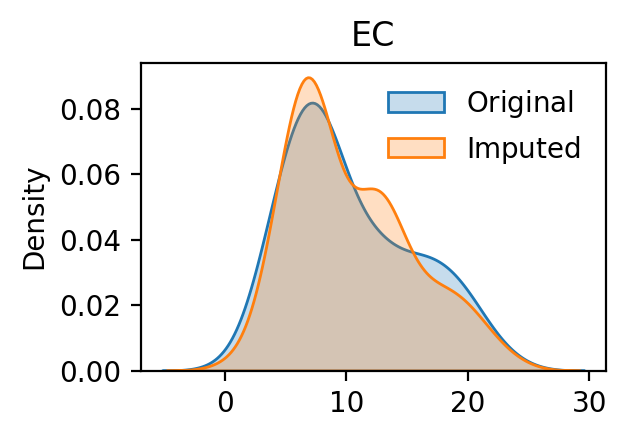

In [24]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

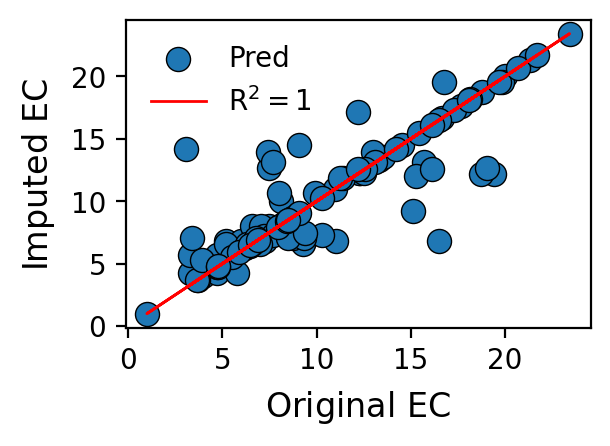

In [25]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [26]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 2.54
MAE: 1.28
R2: 0.76


#### Extra Tree Regressor

In [27]:
# fill data

method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=200)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:22.685 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O     EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  13.30
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20    NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99    NaN
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   6.55
2024-02-15 12:40:22.686 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 12:40:22.687 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:22.687 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:22.687 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:22.688 | 

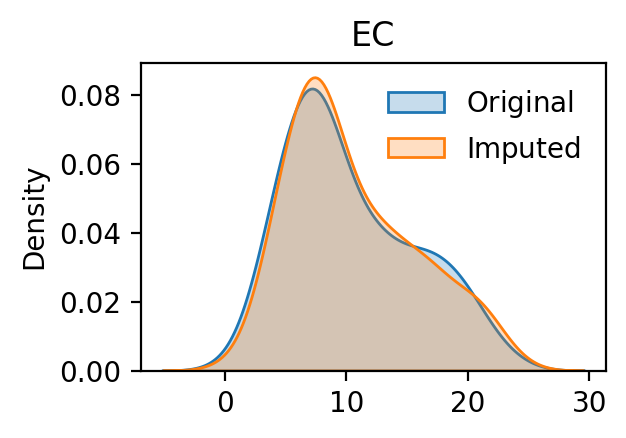

In [28]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

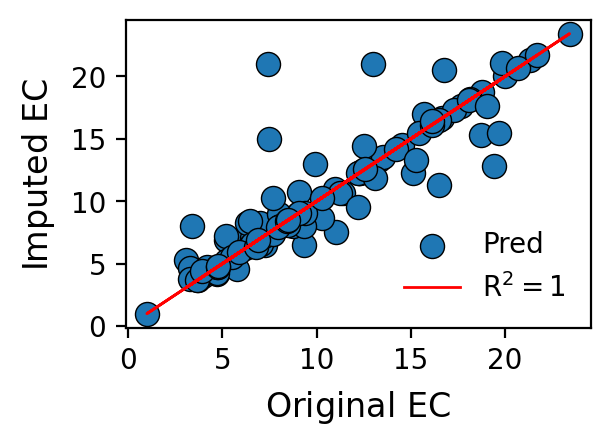

In [29]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [30]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 2.28
MAE: 1.08
R2: 0.81


### Case 3: 70%

In [31]:
missing_fraction = 0.7
clean_data_with_NaN = introduce_missing_values_in_columns(clean_data.copy(), [idx], missing_fraction)
clean_data_with_NaN.head()


,VW,FR,CNaCl,SSA,PV,Psave,PVmicro,ID/IG,N,O,EC
20,1.0,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,NaN
21,1.1,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,5.30
22,1.2,10.0,585.0,1860.0,1.04,2.24,0.94,0.90,0.16,7.20,NaN
183,2.0,10.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,7.25
184,2.0,15.0,25.0,1016.0,0.78,3.07,0.30,0.94,0.46,6.99,NaN


In [32]:
for col in clean_data_with_NaN.columns:
    print(f'% of missing values in {col}: {clean_data_with_NaN[col].isna().sum()/len(clean_data_with_NaN)*100:.2f}%')

% of missing values in VW: 0.00%
% of missing values in FR: 0.00%
% of missing values in CNaCl: 0.00%
% of missing values in SSA: 0.00%
% of missing values in PV: 0.00%
% of missing values in Psave: 0.00%
% of missing values in PVmicro: 0.00%
% of missing values in ID/IG: 0.00%
% of missing values in N: 0.00%
% of missing values in O: 0.00%
% of missing values in EC: 69.52%


#### KNN

In [33]:
# fill data
method = 'KNN'
model = KNNImputer(n_neighbors=5, weights="uniform")


IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:23.352 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O    EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   NaN
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99  7.25
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   NaN
2024-02-15 12:40:23.353 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: KNN

2024-02-15 12:40:23.354 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:23.354 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:23.355 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:23.356 | WARNING  | cdi.dataPre

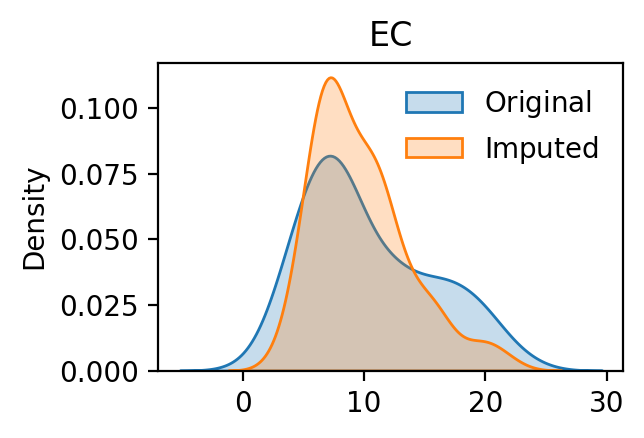

In [34]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

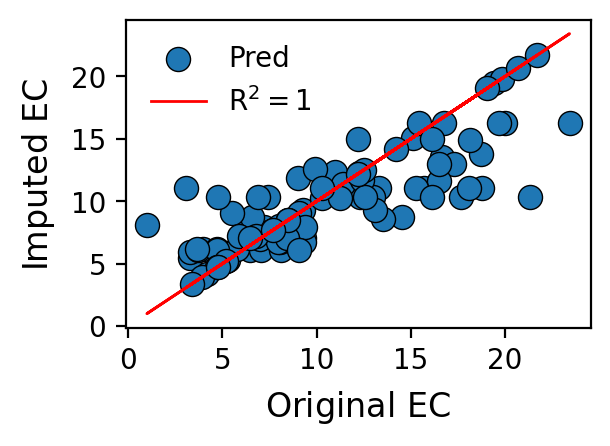

In [35]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [36]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 2.95
MAE: 1.91
R2: 0.68


#### Extra Tree Regressor

In [37]:
# fill data

method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=200)

IMPUTER = Imputation(data=clean_data_with_NaN, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-02-15 12:40:23.953 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:       VW    FR  CNaCl     SSA    PV  Psave  PVmicro  ID/IG     N     O    EC
20   1.0  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   NaN
21   1.1  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20  5.30
22   1.2  10.0  585.0  1860.0  1.04   2.24     0.94   0.90  0.16  7.20   NaN
183  2.0  10.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99  7.25
184  2.0  15.0   25.0  1016.0  0.78   3.07     0.30   0.94  0.46  6.99   NaN
2024-02-15 12:40:23.954 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-02-15 12:40:23.955 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 105
2024-02-15 12:40:23.956 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "VW": 0
2024-02-15 12:40:23.956 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "FR": 0
2024-02-15 12:40:23.957 | WARNIN

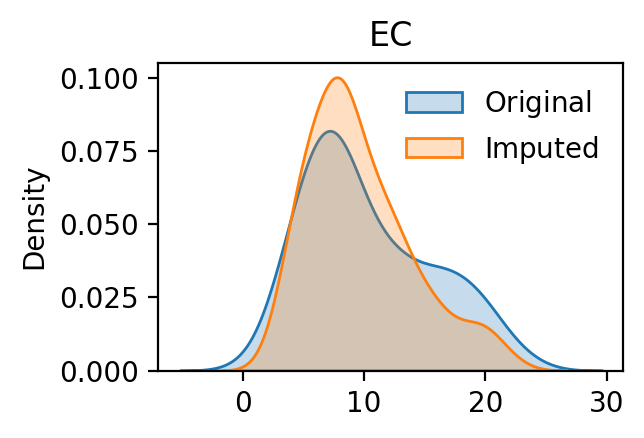

In [38]:
# check if the imputed data is the same as the original data
# plot distribution of the original and imputed data

plotter.plot_kde(
                data = [clean_data[idx].values, df_imputed[idx].values],
                labels = [r'$ \rm Original$', r'$ \rm Imputed$'],
                colors = ['C10', 'C1'],
                property = idx,
                fig_size=(3, 2))

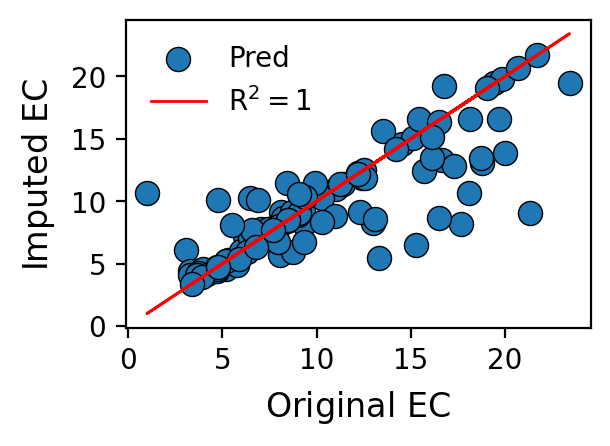

In [39]:
# # plt crossplot
plotter.plot_cross_plot(
                        x = clean_data[idx].values,
                        y = df_imputed[idx].values,
                        x_label = r'$ \rm Original$',
                        y_label = r'$ \rm Imputed$',
                        property = idx,
                        fig_size=(3, 2))

In [40]:
# performance metrics
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
print(f'IDX {idx}')
print(f'RMSE: {root_mean_squared_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'MAE: {mean_absolute_error(clean_data[idx].values, df_imputed[idx].values):.2f}')
print(f'R2: {r2_score(clean_data[idx].values, df_imputed[idx].values):.2f}')

IDX EC
RMSE: 3.02
MAE: 1.69
R2: 0.67
